# 評価方法

分類されていないデータを認識し、どれだけ正しくカテゴリごとに分類できるかを算出した「平均精度」の高さを競い合います。

今回、活用するデータはLSWMD_25519となります。
LSWMD_25519のFailureType項目が分類されていない状態のデータに対し、正しいFailureTypeカテゴリを分類するプログラムを作成し、その平均精度を算出します。
平均精度とは、カテゴリごとに正しく分類できる精度を平均した値です。カテゴリごとに算出した精度（Aが正しく分類された数/Aのデータ数）を足し、カテゴリ数で割ります。

公平な評価を実施するために、以下の制限を設けています。
1. 外部パッケージをインストールするためのセルとsolution関数の中身のみを編集すること
2. 校舎のiMac上で最後のセルの実行時間が15分未満であること　（%%timeitの出力結果を確認してください）

※気になる点がある場合、Discordで気軽にお問合せください。

In [1]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

外部パッケージを使用する場合、以下の方法でインストールを実施してください。

In [2]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
# !pip install keras
# !pip install tensorflow[and-cuda]
!pip install tensorflow
!pip install Pillow

以下のsolution関数のみ編集してください。

In [3]:
def solution_random(x_test_df, train_df):
    # こちらの関数の中身を編集してください。
    import random
    failure_types = list(train_df['failureType'].unique())
    num_rows = len(x_test_df)
    while len(failure_types) < num_rows:
        failure_types.append(random.choice(failure_types))

    return pd.DataFrame({'failureType': failure_types}, index=x_test_df.index)

In [4]:
def normalize_map(map, resize_shape=(64,64)):
    import numpy as np
    from PIL import Image

    (len_y,len_x) = map.shape
    y_add = len_y // 2 + len_y % 2
    x_add = len_x // 2 + len_x % 2
    for y in range(len_y):
        for x in range(len_x):
            if map[y][x] == 0:
                pic = map[(y + y_add) % len_y][(x + x_add) % len_x]
                if pic == 0:
                    map[(y + y_add) % len_y][(x + x_add) % len_x] = 1
                    map[y][x] = 1
                else :
                    map[y][x] = pic
    return np.asarray(Image.fromarray(map - 1.0).resize(resize_shape))
    

def create_model(input_shape=(64,64,1), num_classes=1000):
    import tensorflow as tf
    layers = tf.keras.layers


    return tf.keras.models.Sequential([
        layers.Conv2D(24, 3, activation='relu', padding='same', input_shape=(input_shape)),
        layers.MaxPooling2D(pool_size=2, padding='same'),
        layers.Conv2D(24, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=2),
        layers.Conv2D(24, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=2),
        layers.Flatten(),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(num_classes, activation=tf.nn.softmax),
    ])

def show_img(image):
    import matplotlib.pyplot as plt

    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

def solution(x_test_df, train_df):
    import numpy as np
    import tensorflow as tf

    failure_types = list(train_df['failureType'].unique())
    #前処理
    normalized_train_maps = np.array([normalize_map(x) for x in train_df['waferMap']])
    print(normalized_train_maps.shape)
    normalized_train_maps = np.concatenate((normalized_train_maps, np.rot90(normalized_train_maps, k=2, axes=(1, 2))), axis=0)
    normalized_train_maps = np.concatenate((normalized_train_maps, np.rot90(normalized_train_maps, k=1, axes=(1, 2))), axis=0)
    normalized_train_maps = np.concatenate((normalized_train_maps, np.swapaxes(normalized_train_maps, 1, 2)), axis=0)
    normalized_train_maps = normalized_train_maps.reshape(normalized_train_maps.shape + (1,))
    train_labels = np.array([failure_types.index(x) for x in train_df['failureType']] * 8)
    show_img(normalized_train_maps[0])
    print(normalized_train_maps.shape)
    print(train_labels.shape)
    
    #ネットワークを準備
    model = create_model(input_shape=normalized_train_maps[0].shape,num_classes=len(failure_types))
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    #学習
    model.fit(normalized_train_maps, train_labels, epochs=4)
    
    normalized_test_maps = np.array([normalize_map(x) for x in x_test_df['waferMap']])
    normalized_test_maps = normalized_test_maps.reshape(normalized_test_maps.shape + (1,))
    test_index = [x for x in x_test_df['waferIndex']]
    predictions = model.predict(normalized_test_maps)
    answer = [failure_types[x.argmax()] for x in predictions]
    return pd.DataFrame({'failureType': answer}, index=x_test_df.index)




solution関数は以下のように活用され、平均精度を計算します。

(22967, 64, 64)


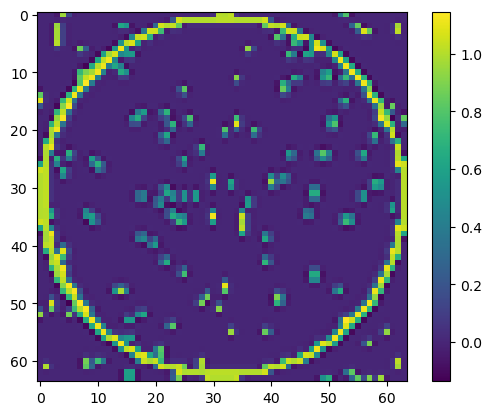

(183736, 64, 64, 1)
(183736,)


2023-11-16 07:52:51.237890: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3010330624 exceeds 10% of free system memory.


Epoch 1/4


/opt/conda/lib/python3.11/site-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5742/5742 [==============================] - 114s 19ms/step - loss: 0.2743 - accuracy: 0.8992
Epoch 2/4
5742/5742 [==============================] - 118s 20ms/step - loss: 0.1504 - accuracy: 0.9439
Epoch 3/4
5742/5742 [==============================] - 125s 22ms/step - loss: 0.1240 - accuracy: 0.9534
Epoch 4/4
80/80 [==============================] - 1s 7ms/step
平均精度：93.84%


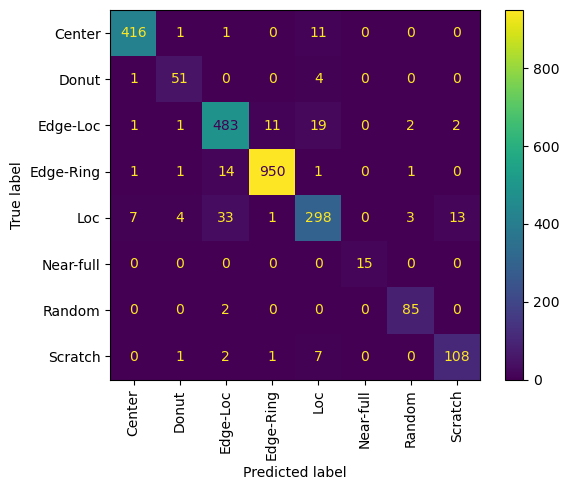

誤分類されたデータ:
                                                waferMap  dieSize   lotName  \
24617  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,...    562.0  lot46963   
22429  [[1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,...   1109.0  lot45540   
17960  [[1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1,...    776.0  lot41033   
18743  [[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,...    845.0  lot42342   
18880  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...   1197.0  lot42390   
...                                                  ...      ...       ...   
18881  [[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,...   1198.0  lot42391   
20038  [[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,...   1256.0  lot43778   
17279  [[1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1,...    533.0  lot40476   
22852  [[1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,...    904.0  lot45634   
17671  [[1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,...    776.0  lot40792   

       waferIndex failureType  
24617   

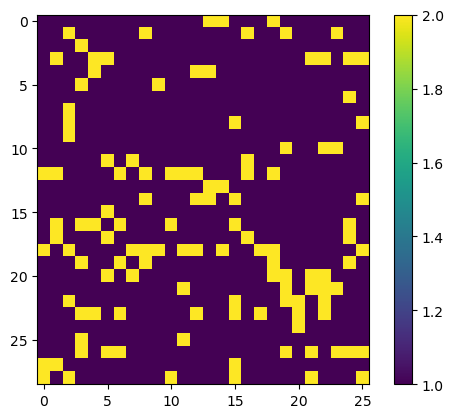

(39, 37)


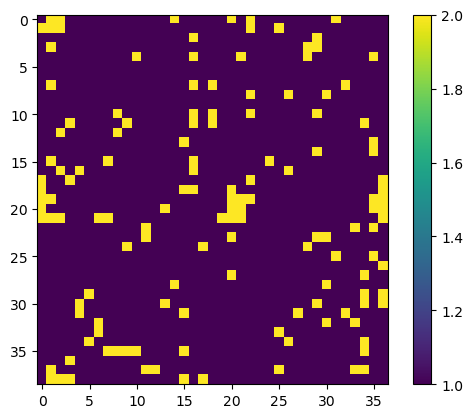

(30, 34)


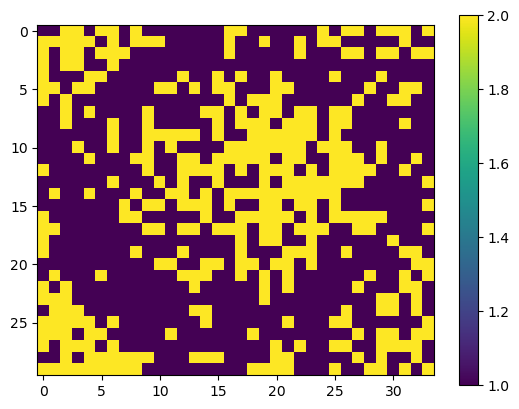

(35, 31)


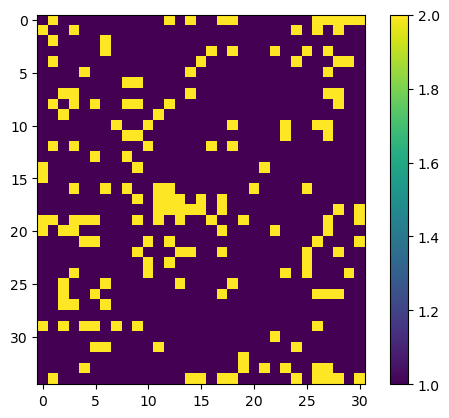

(38, 40)


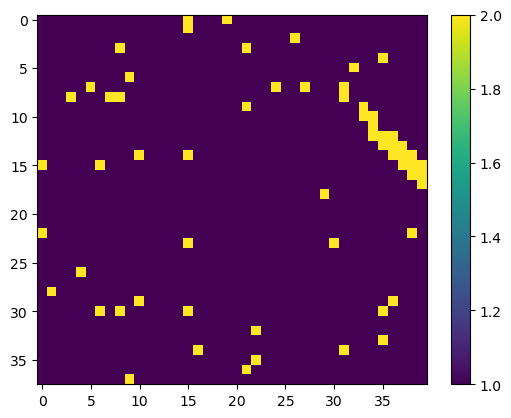

(32, 29)


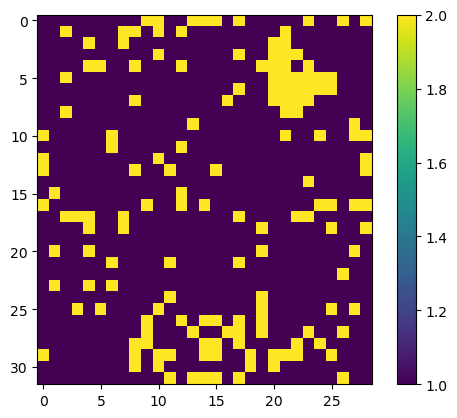

(29, 26)


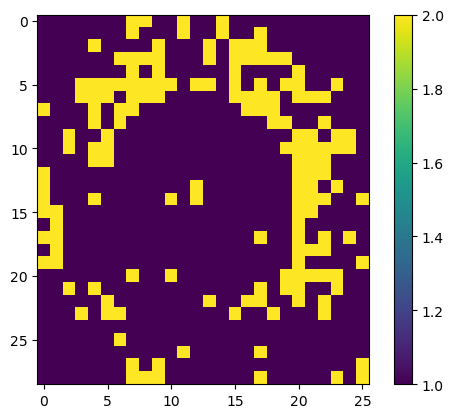

(26, 26)


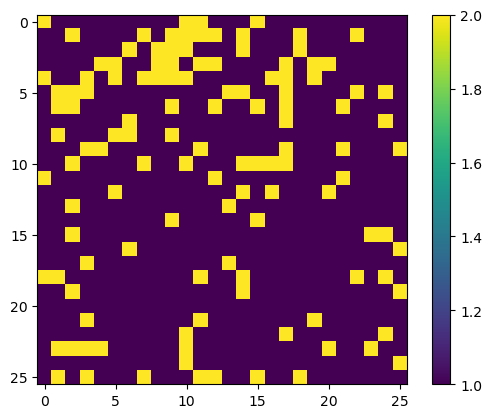

(37, 42)


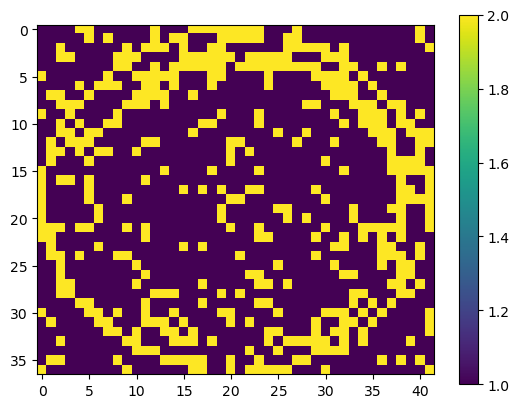

(25, 26)


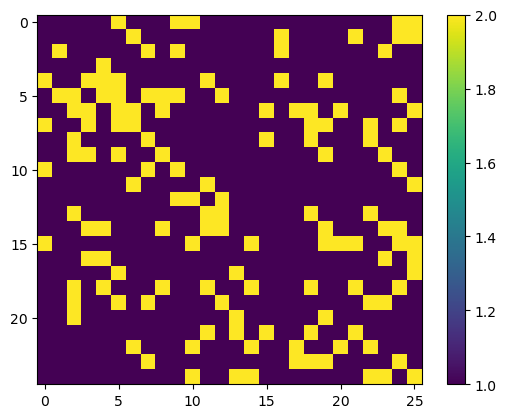

(33, 29)


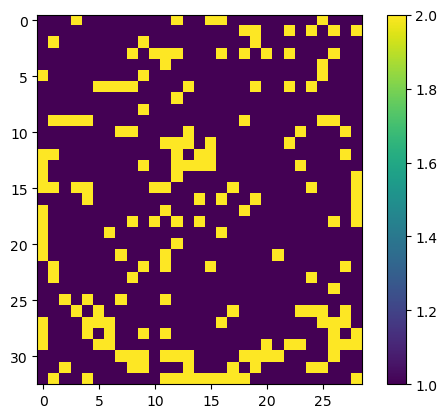

(32, 29)


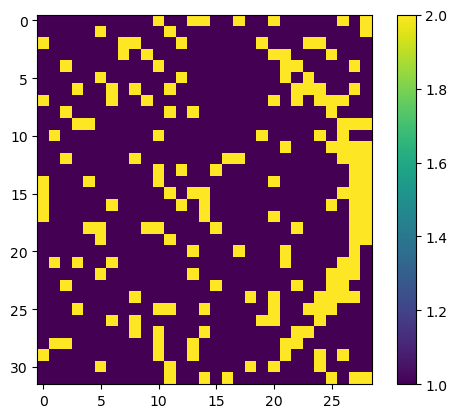

(26, 26)


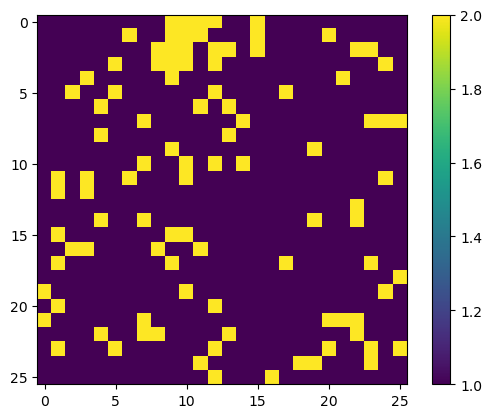

(133, 97)


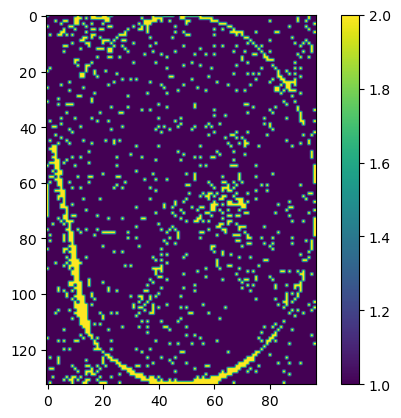

(34, 34)


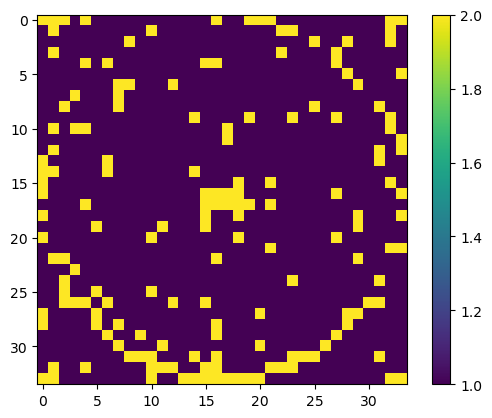

(26, 26)


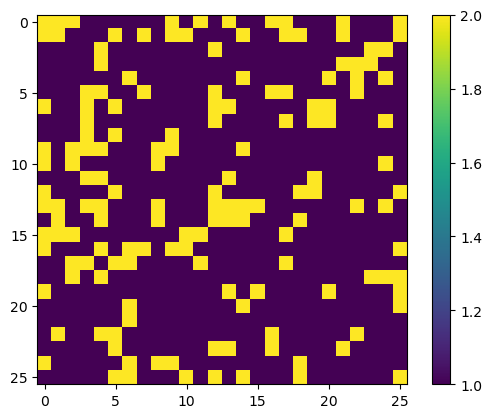

(34, 34)


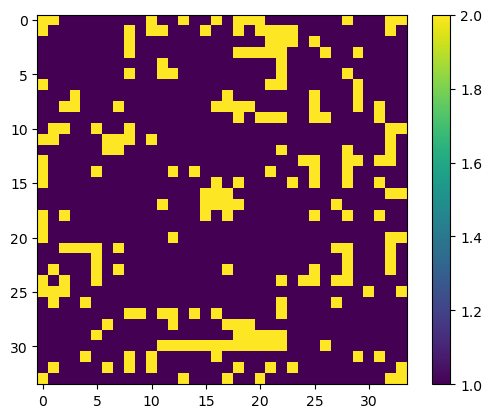

(39, 37)


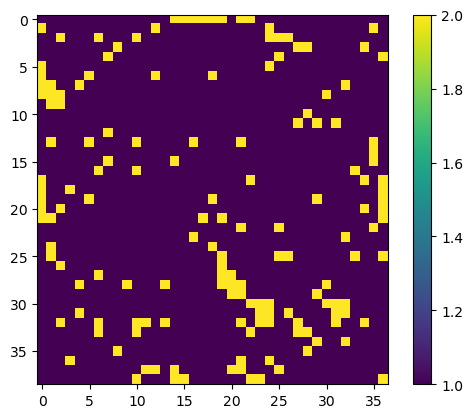

(33, 29)


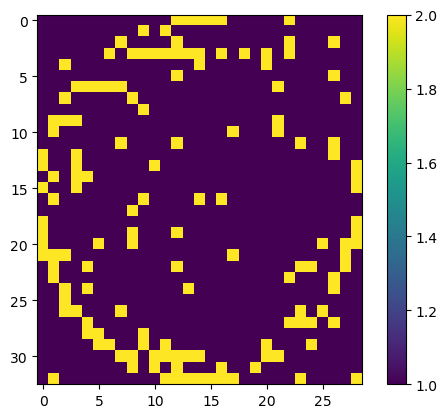

(39, 37)


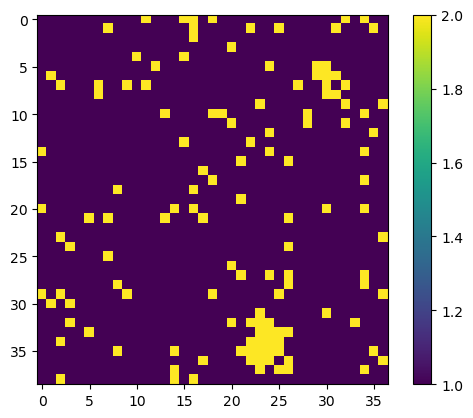

(29, 26)


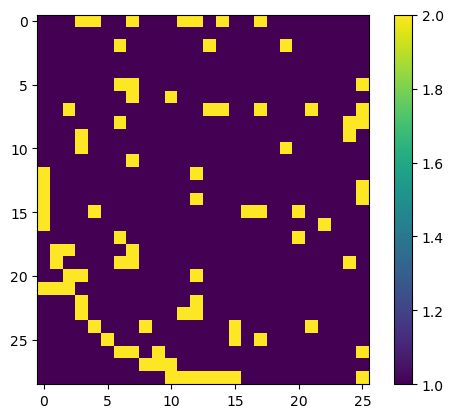

(26, 30)


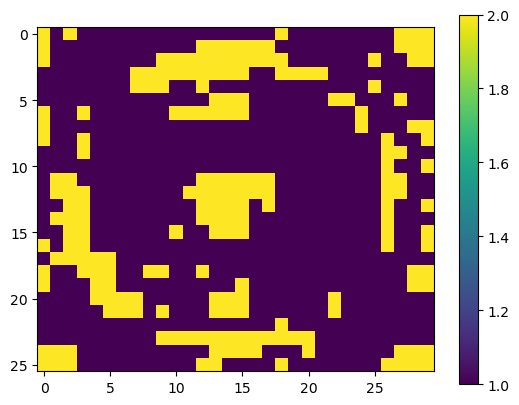

(44, 41)


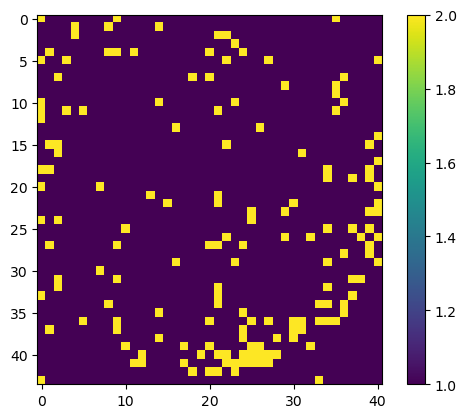

(26, 26)


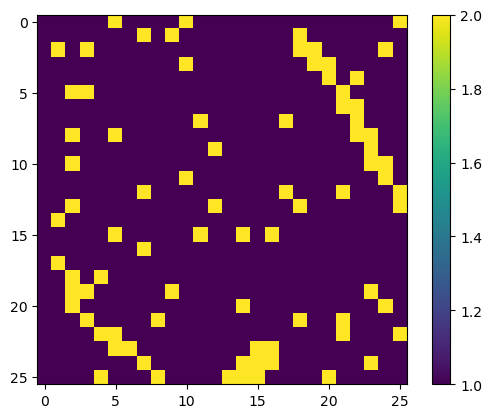

(33, 29)


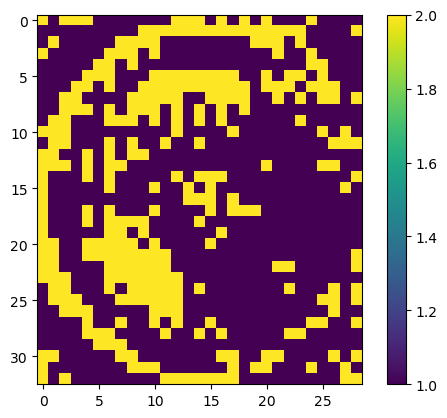

(29, 26)


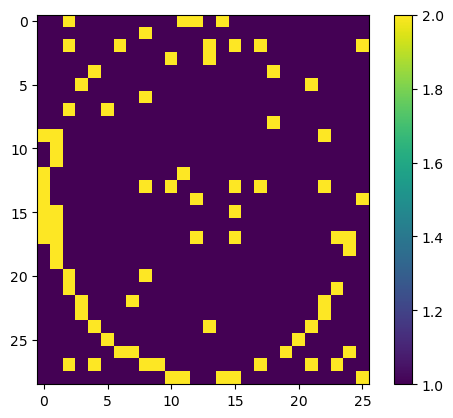

(70, 58)


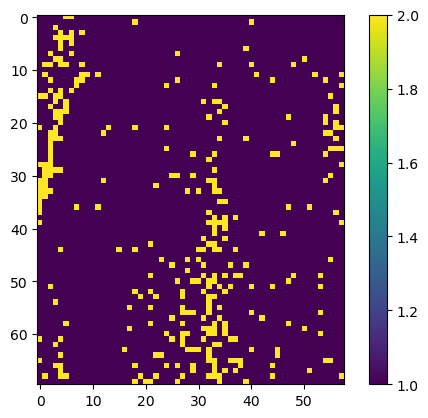

(25, 26)


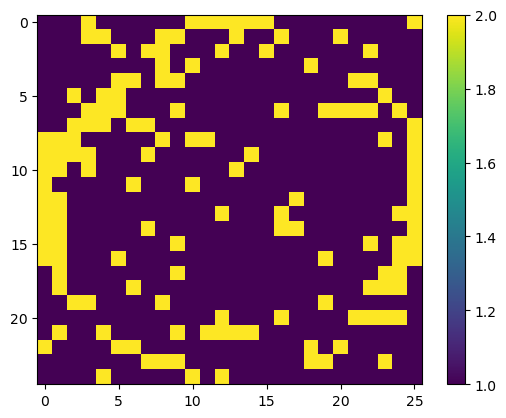

(70, 75)


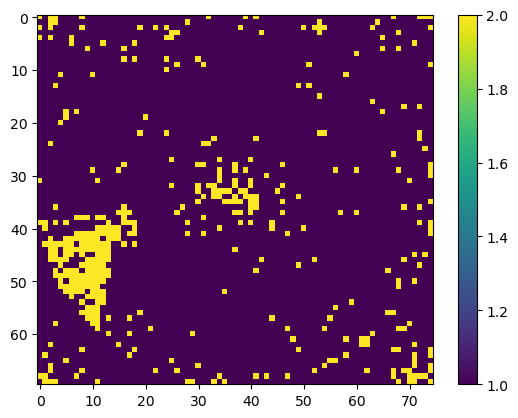

(26, 30)


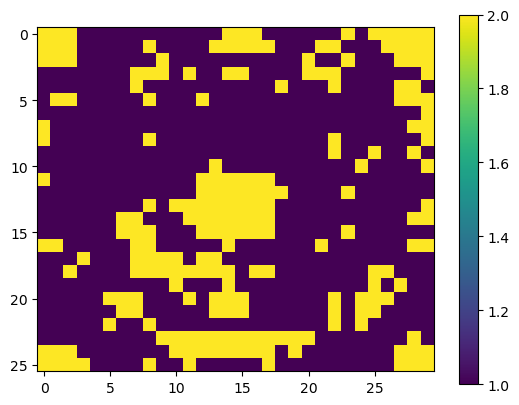

(29, 26)


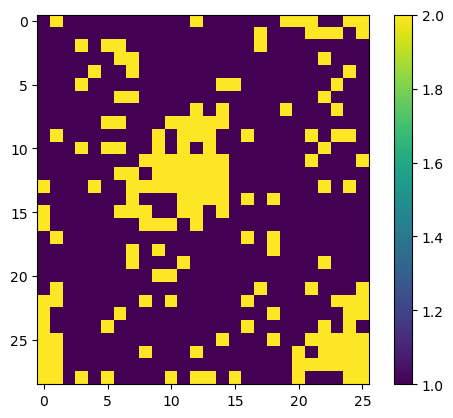

(30, 34)


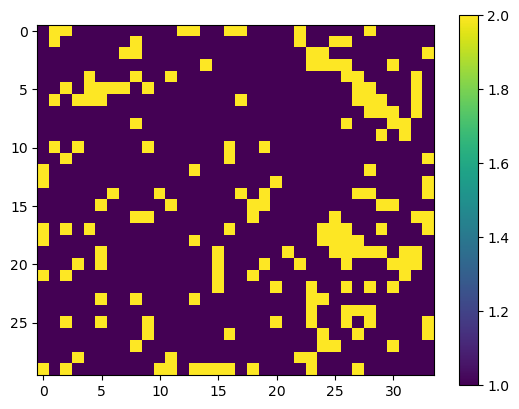

(22, 50)


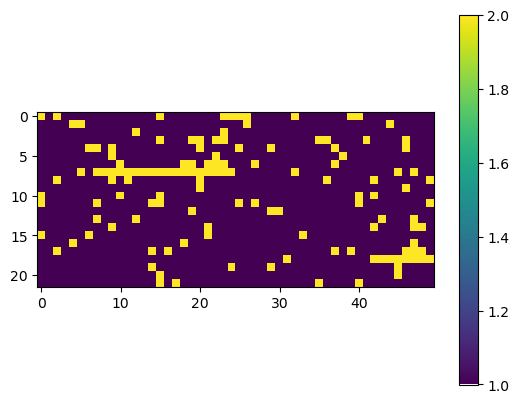

(44, 44)


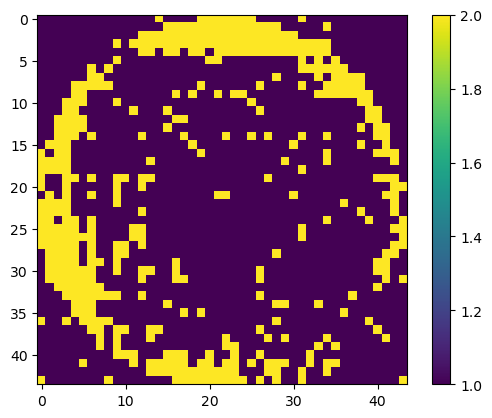

(57, 64)


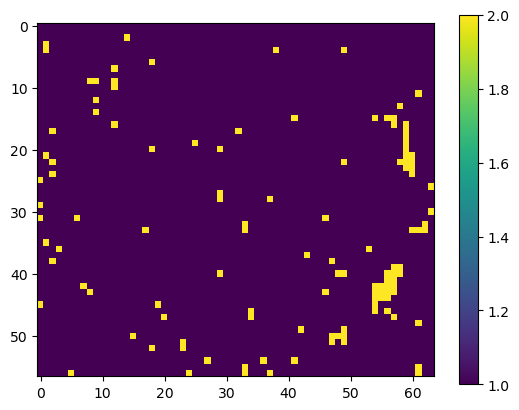

(26, 26)


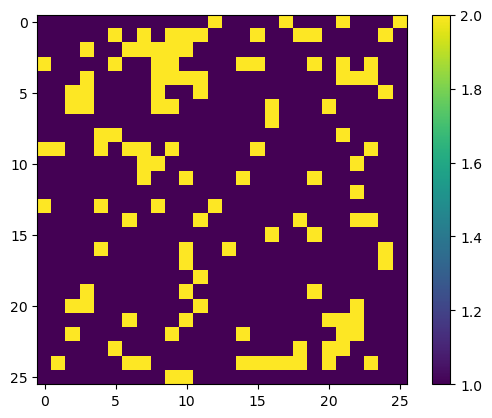

(33, 33)


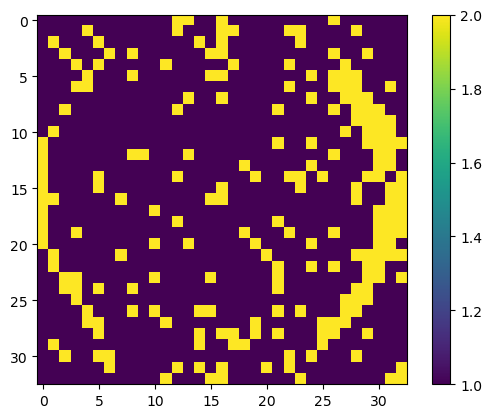

(29, 26)


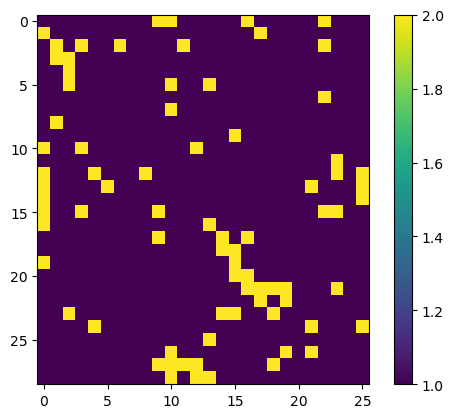

(29, 26)


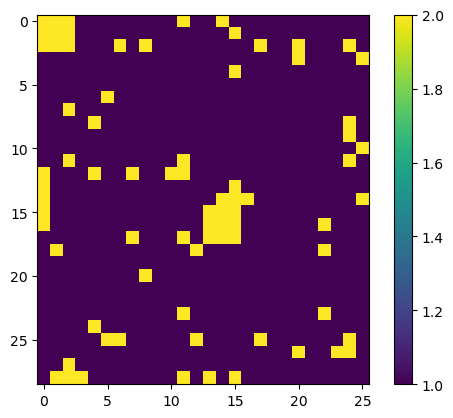

(30, 34)


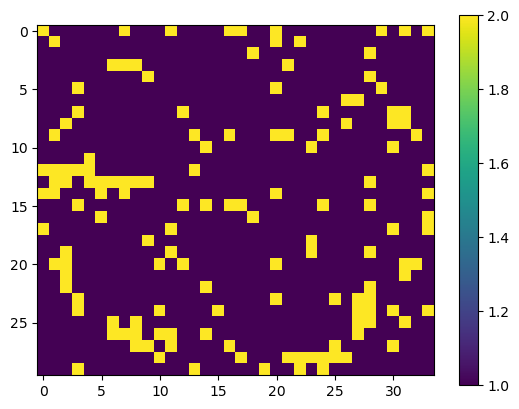

(26, 30)


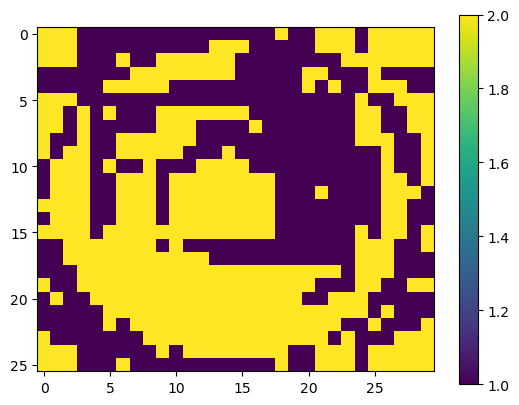

(35, 31)


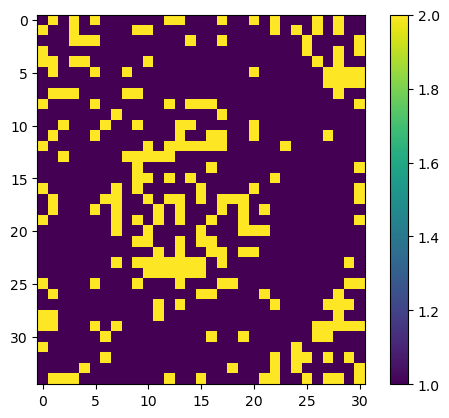

(29, 27)


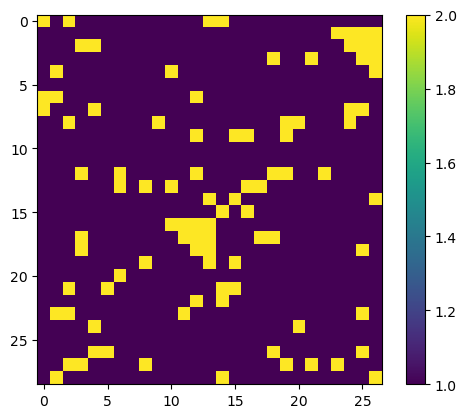

(41, 42)


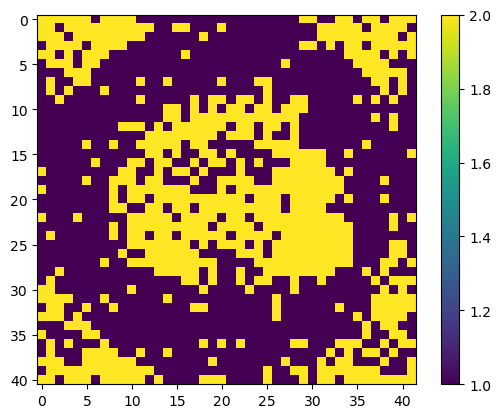

(43, 42)


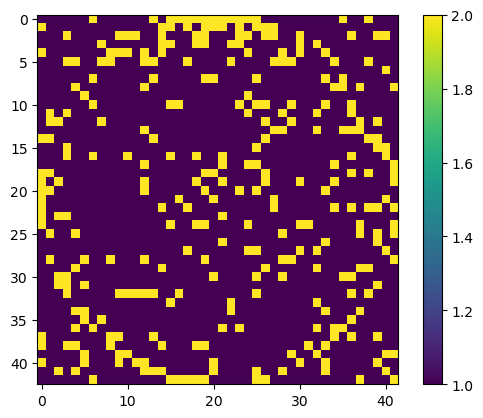

(39, 37)


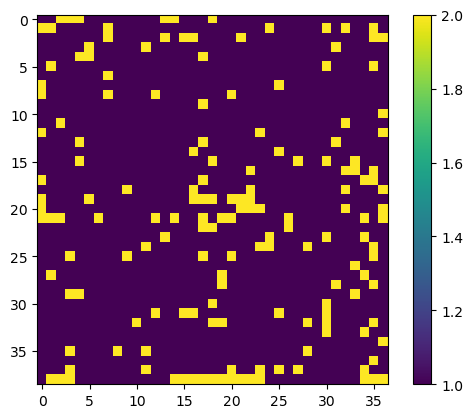

(35, 31)


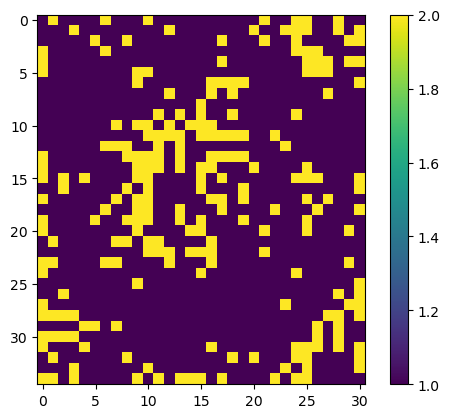

(30, 34)


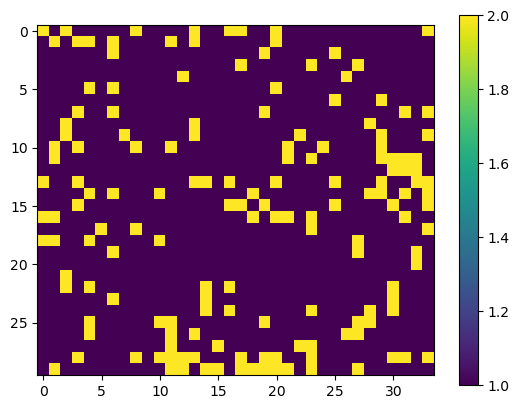

(44, 41)


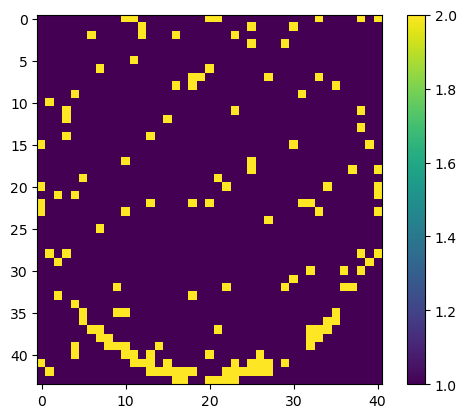

(44, 44)


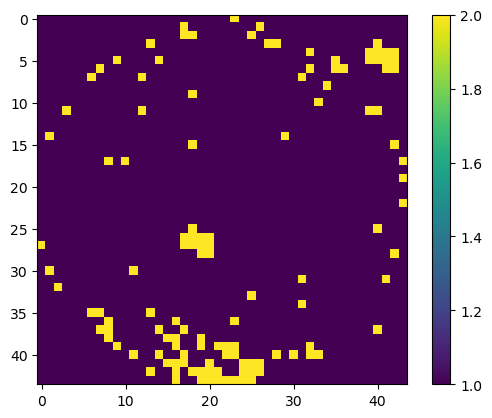

(25, 27)


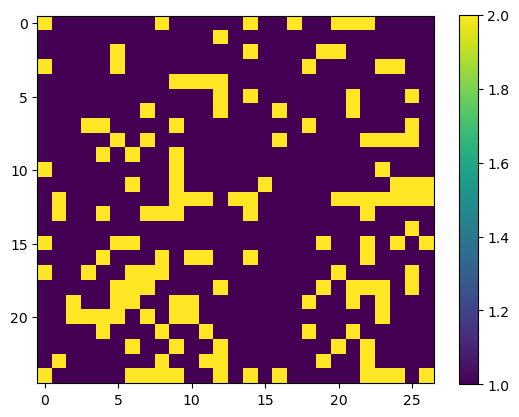

(26, 30)


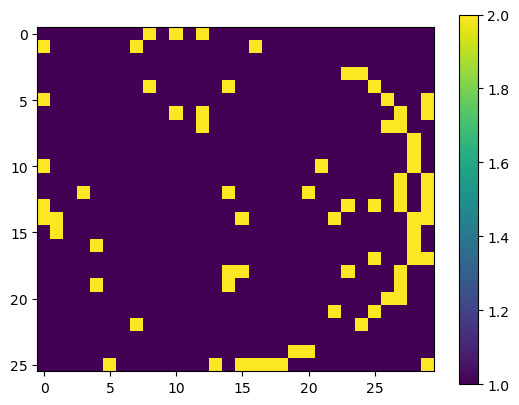

(26, 30)


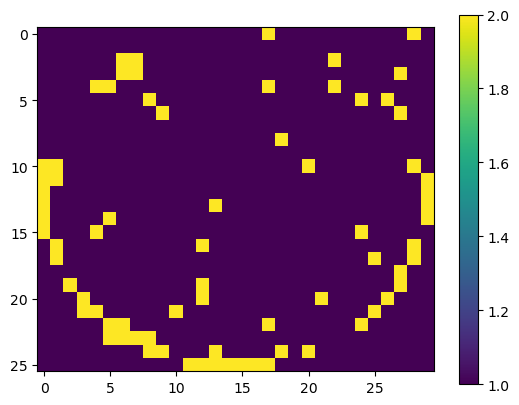

(39, 37)


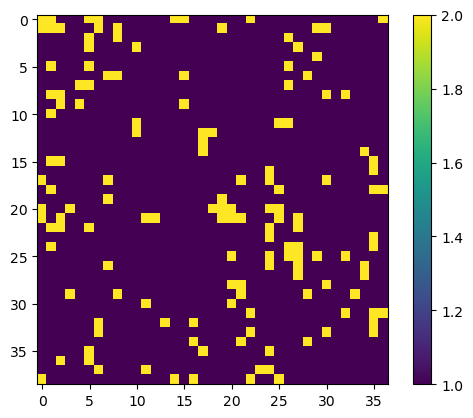

(26, 26)


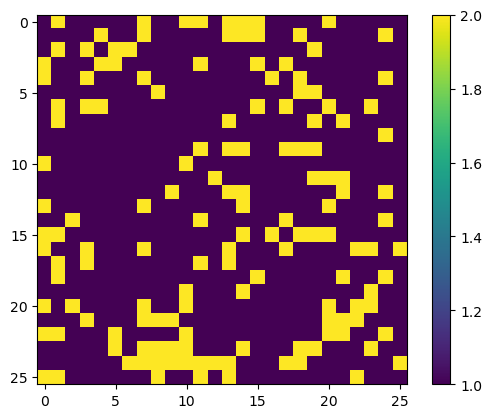

(26, 26)


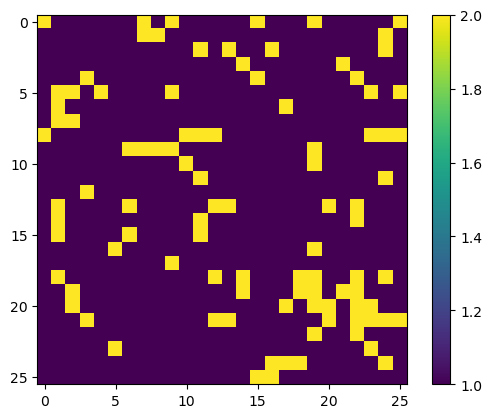

(29, 26)


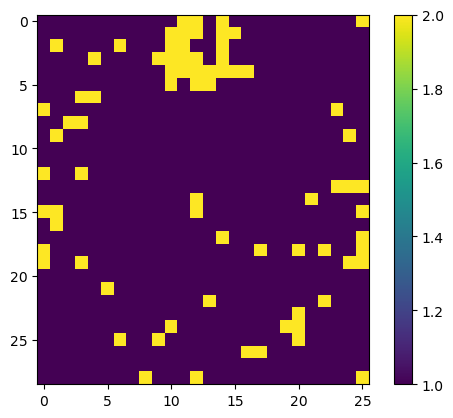

(27, 25)


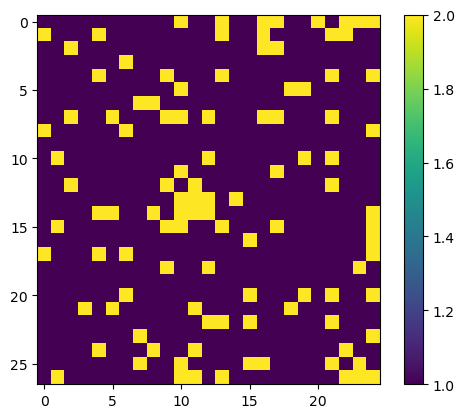

(39, 37)


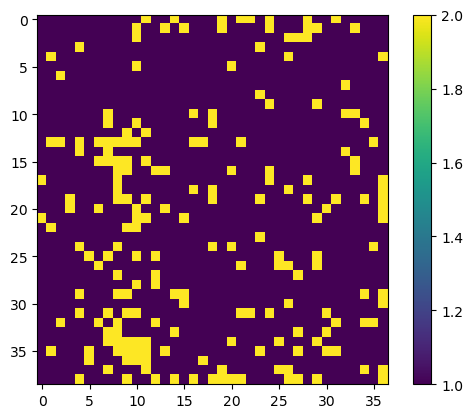

(41, 42)


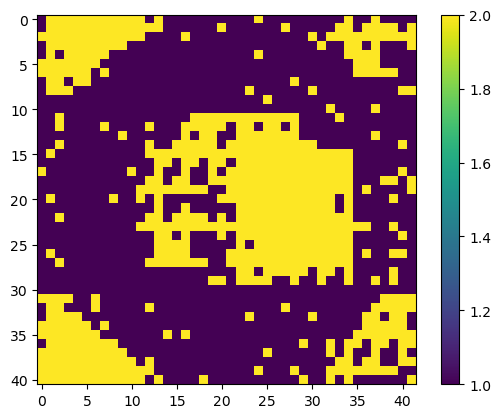

(33, 33)


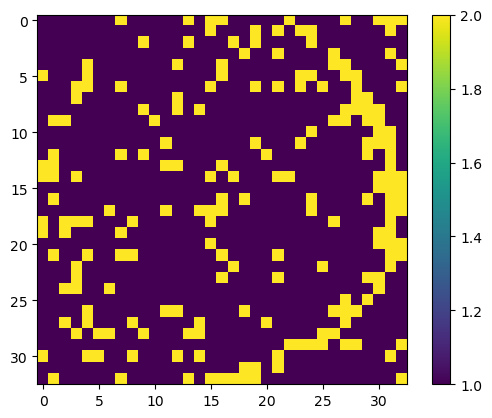

(30, 34)


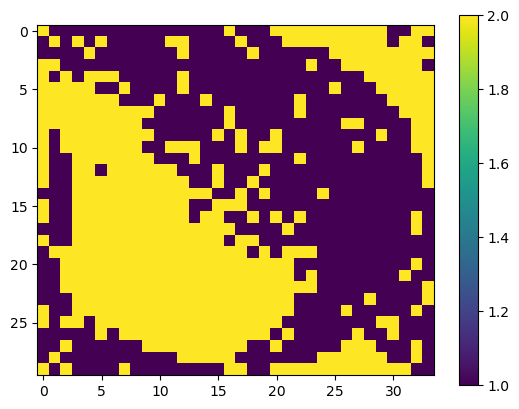

(56, 41)


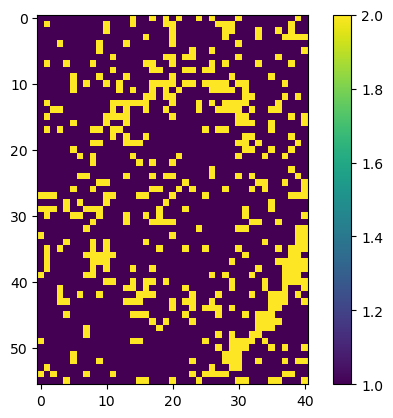

(26, 30)


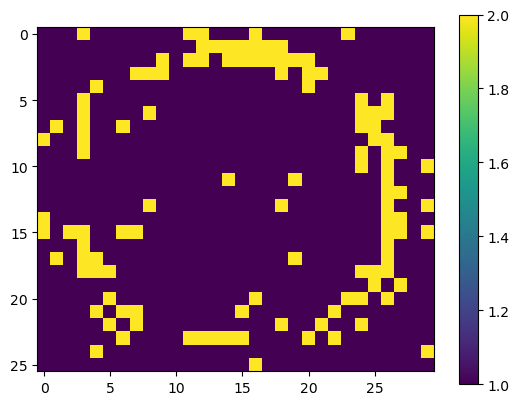

(51, 30)


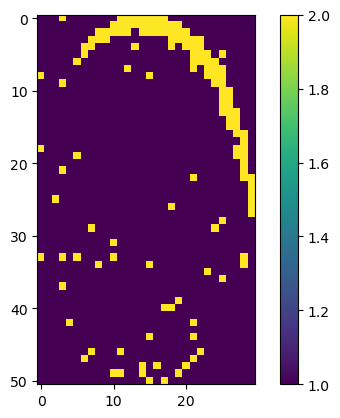

(37, 37)


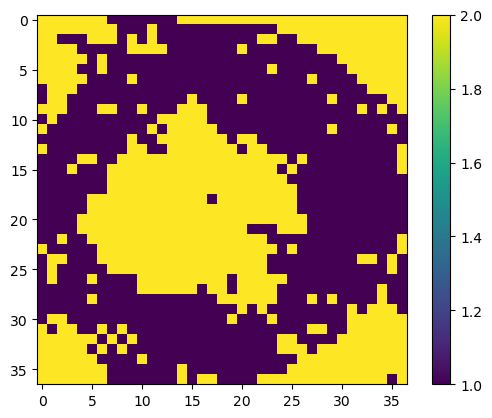

(60, 55)


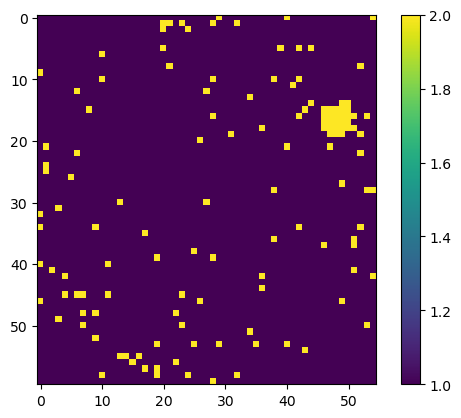

(26, 26)


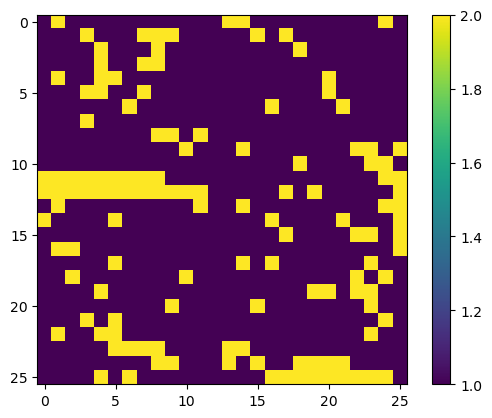

(30, 34)


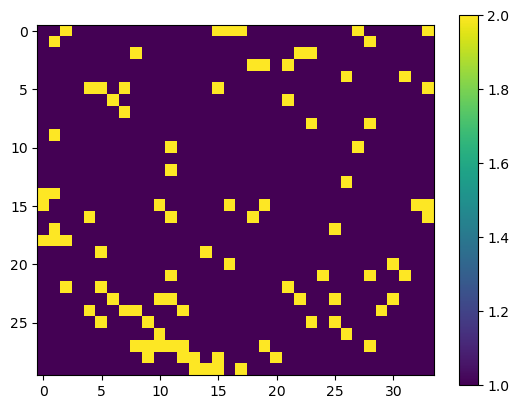

(29, 26)


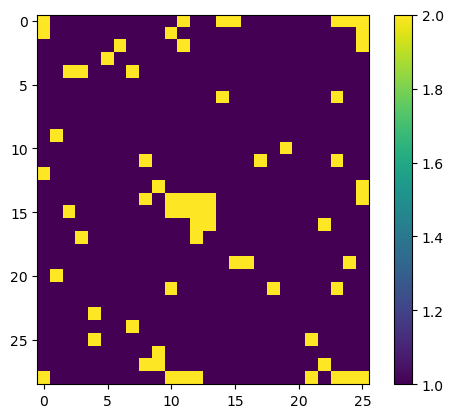

(37, 37)


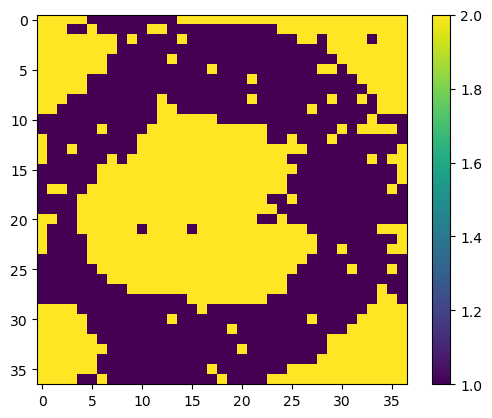

(29, 26)


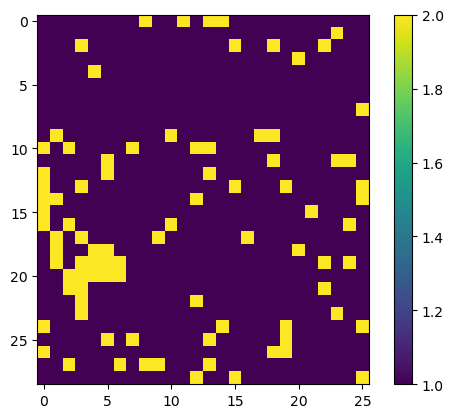

(30, 34)


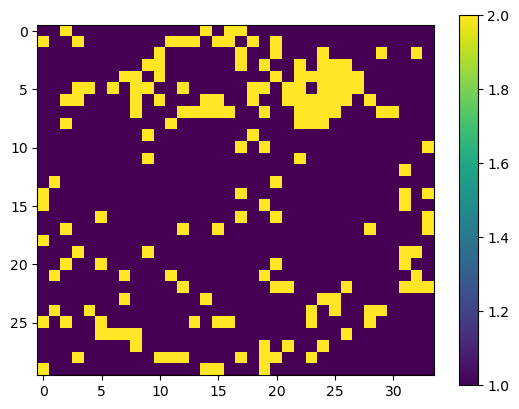

(44, 41)


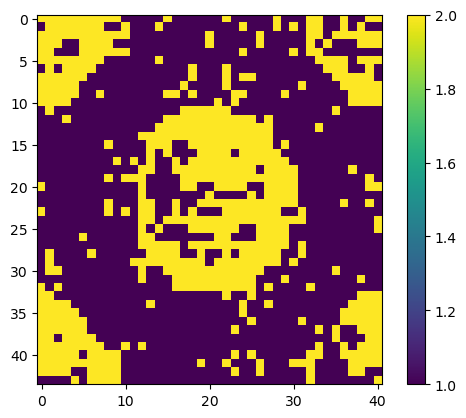

(35, 31)


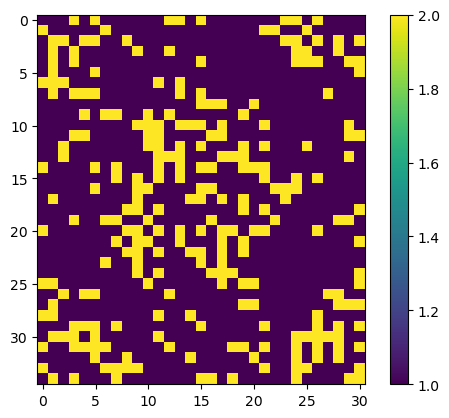

(39, 37)


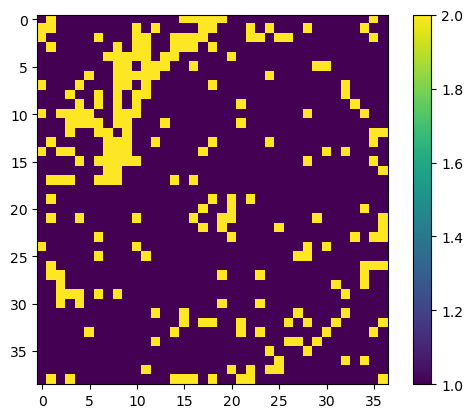

(25, 26)


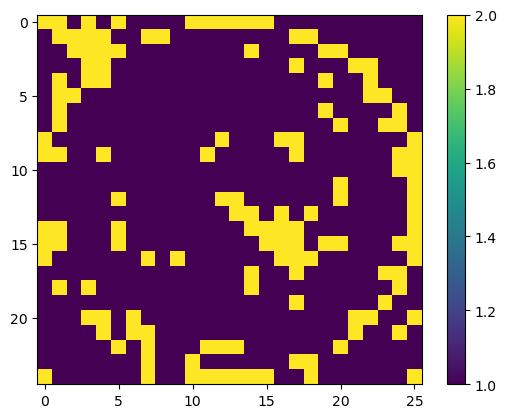

(48, 51)


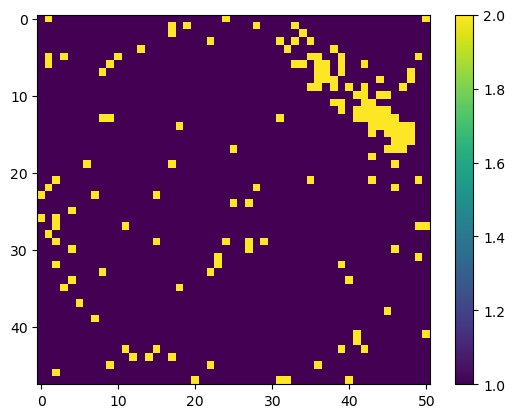

(30, 34)


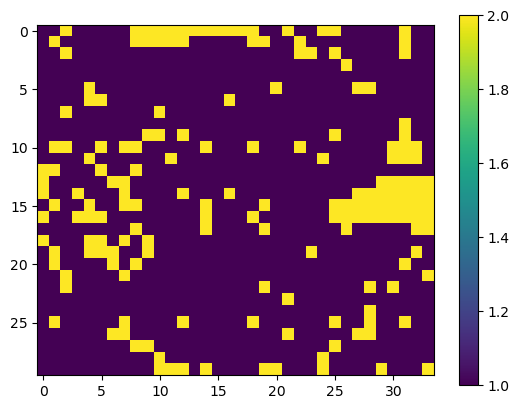

(42, 44)


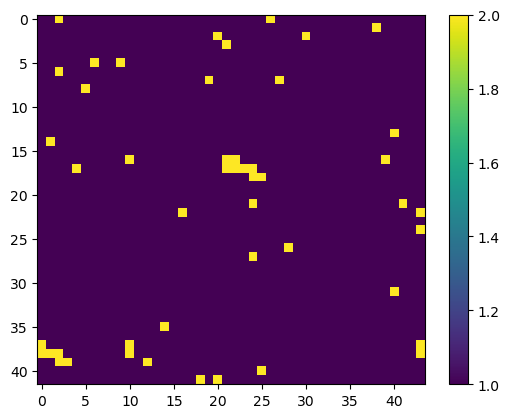

(54, 71)


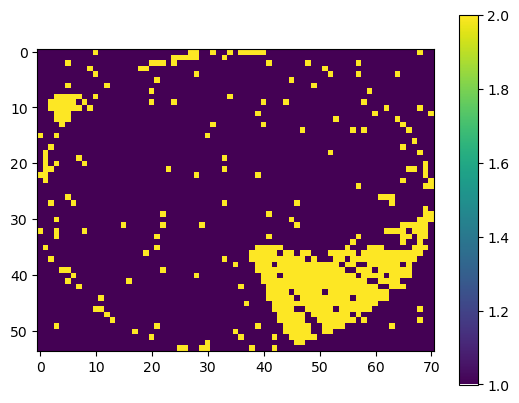

(27, 25)


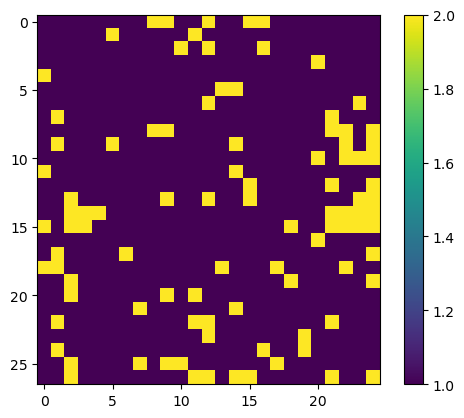

(29, 26)


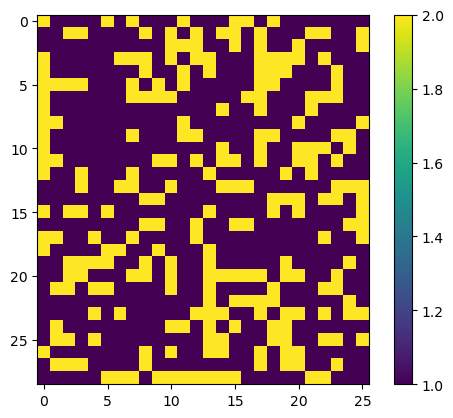

(41, 42)


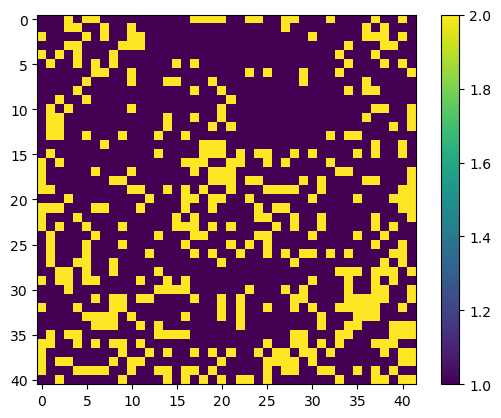

(33, 29)


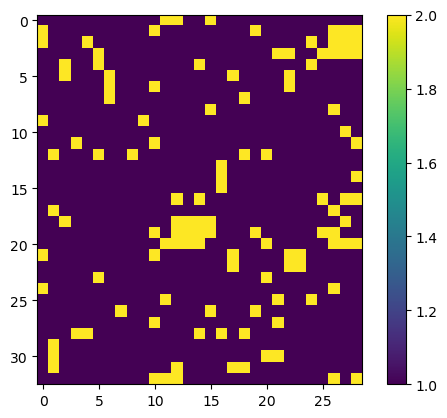

(41, 38)


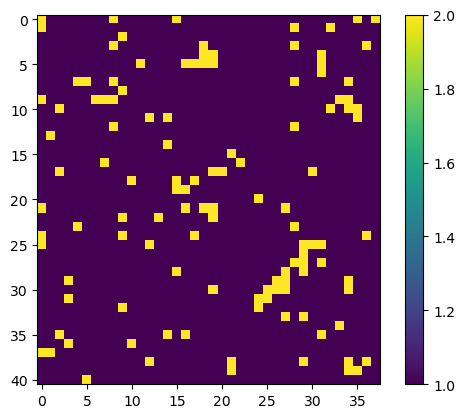

(51, 30)


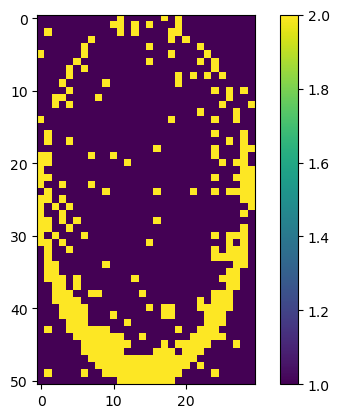

(33, 29)


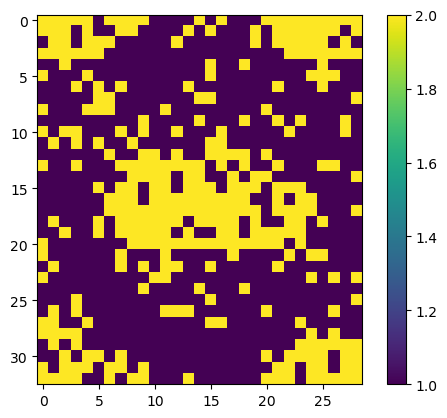

(43, 44)


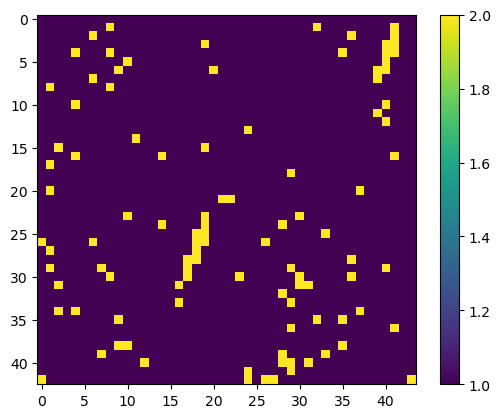

(42, 44)


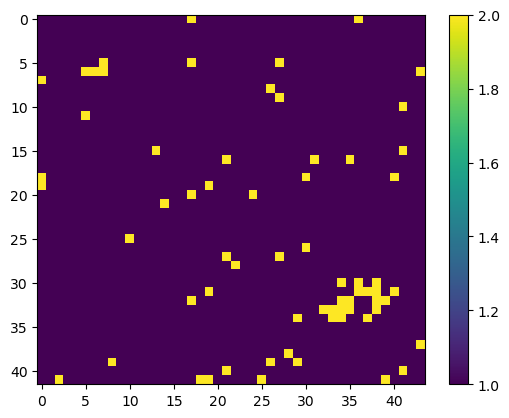

(43, 42)


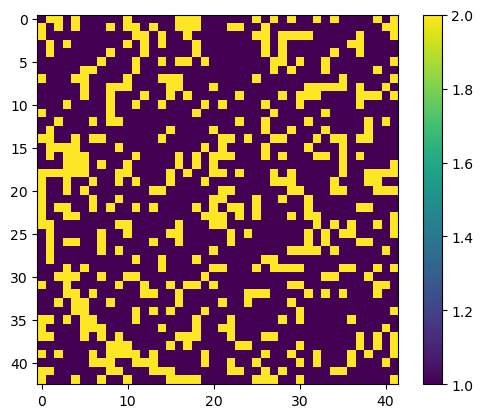

(25, 26)


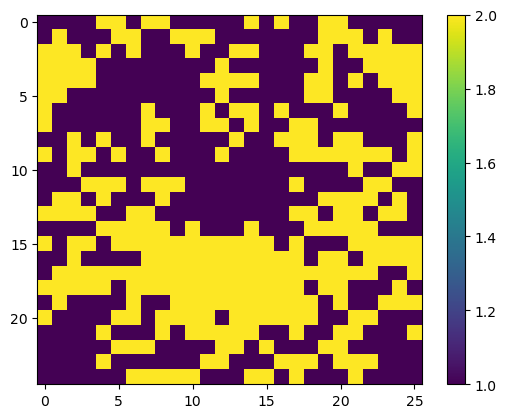

(42, 44)


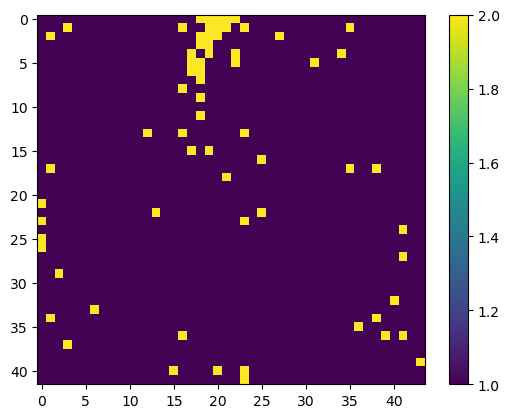

(43, 42)


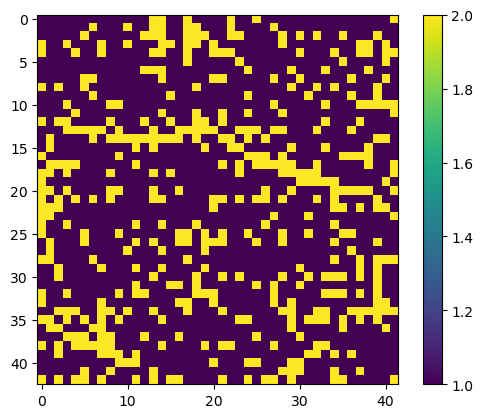

(30, 34)


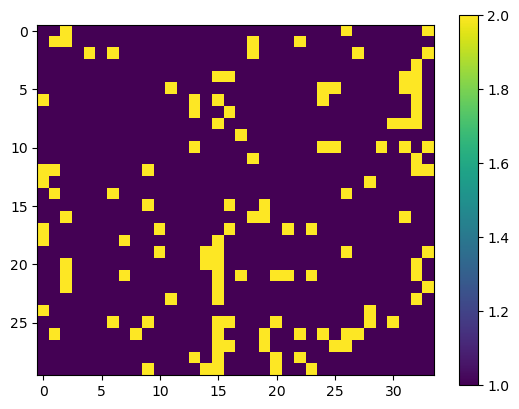

(43, 42)


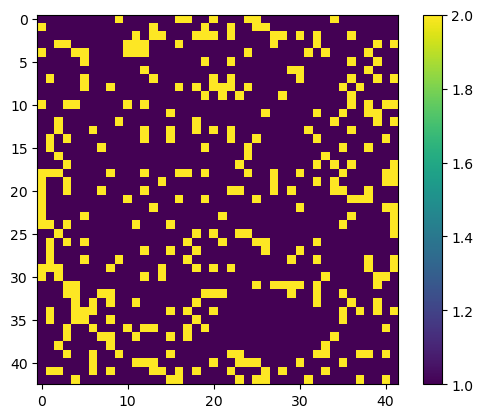

(44, 41)


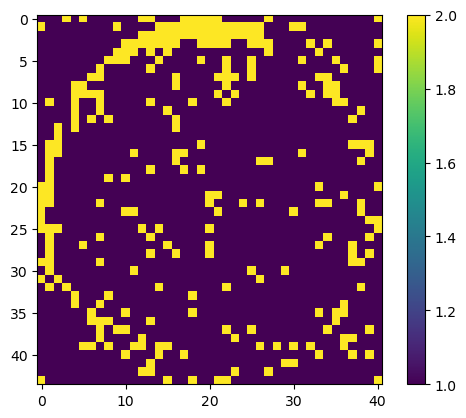

(30, 34)


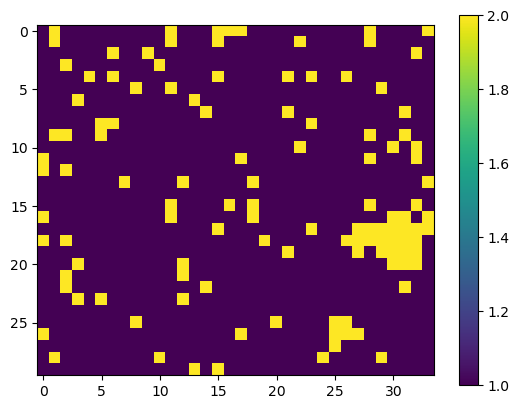

(41, 33)


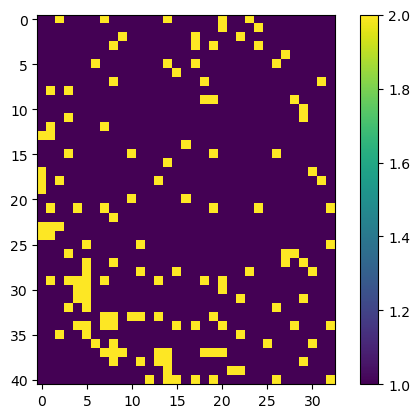

(48, 51)


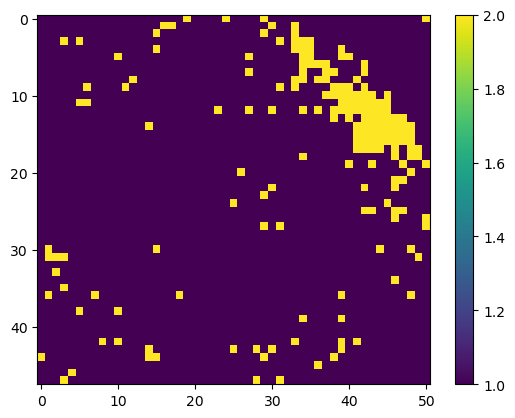

(26, 30)


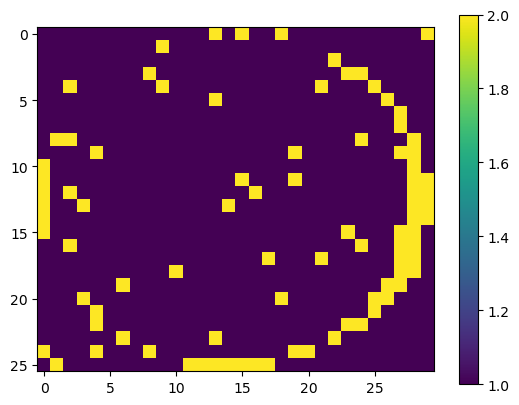

(33, 37)


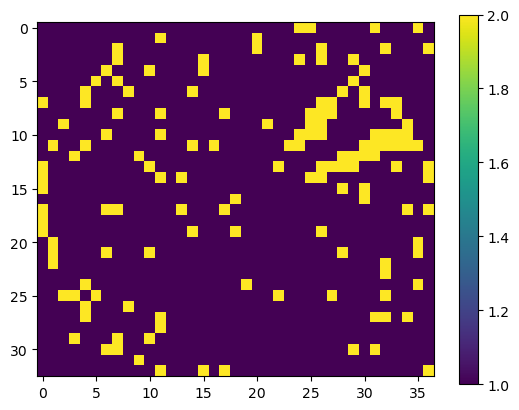

(44, 41)


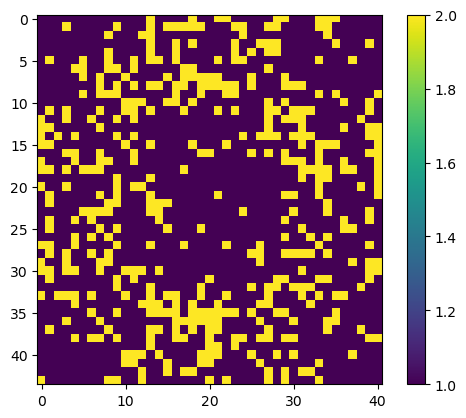

(29, 26)


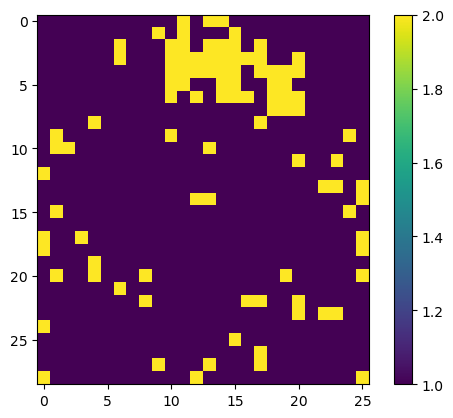

(36, 38)


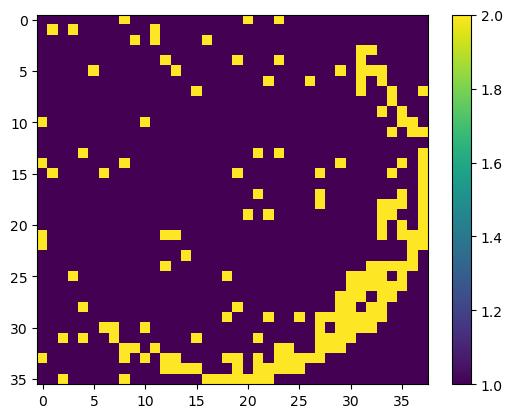

(44, 41)


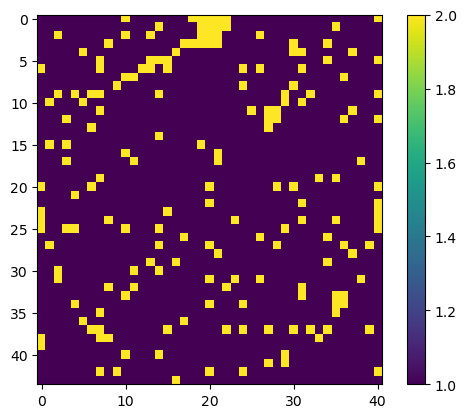

(45, 42)


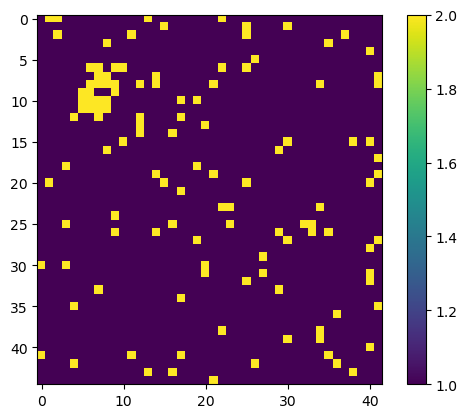

(33, 32)


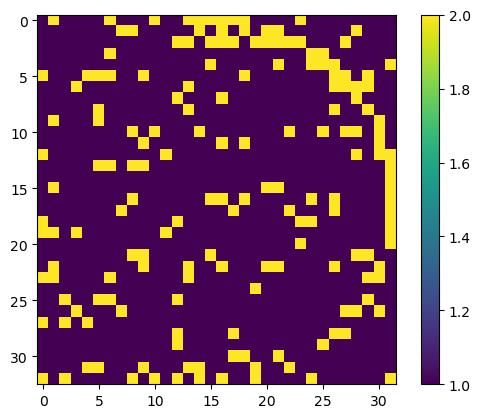

(25, 27)


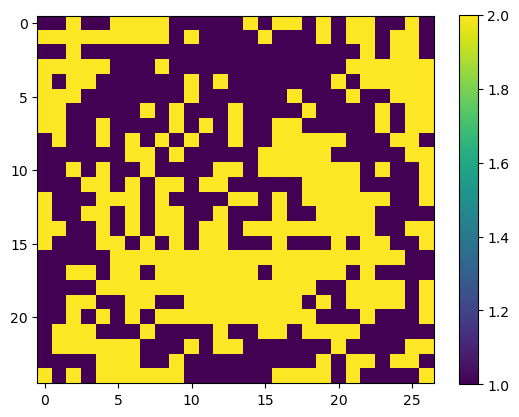

(45, 43)


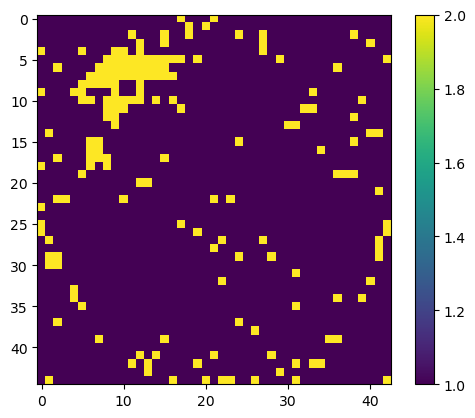

(30, 34)


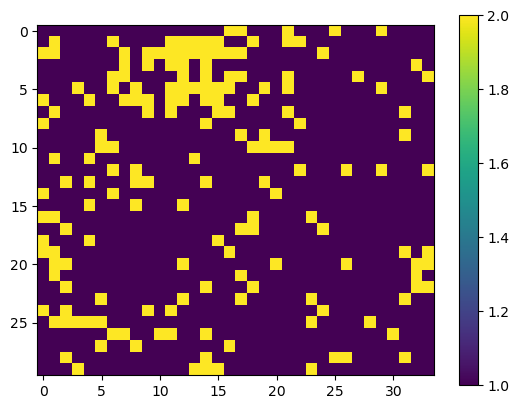

(33, 29)


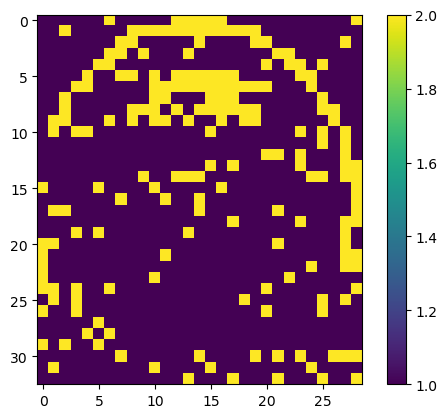

(33, 29)


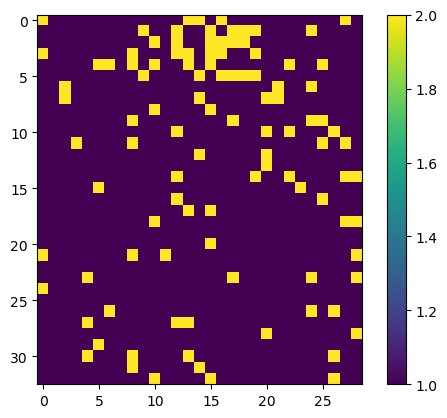

(34, 34)


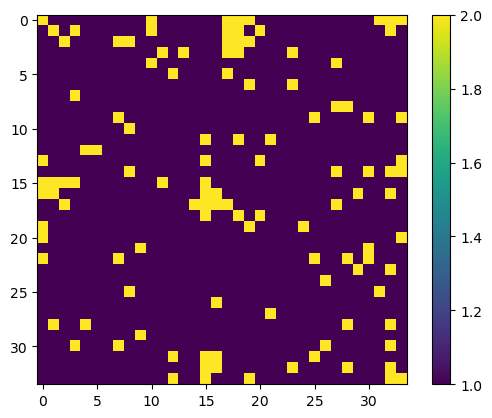

(39, 37)


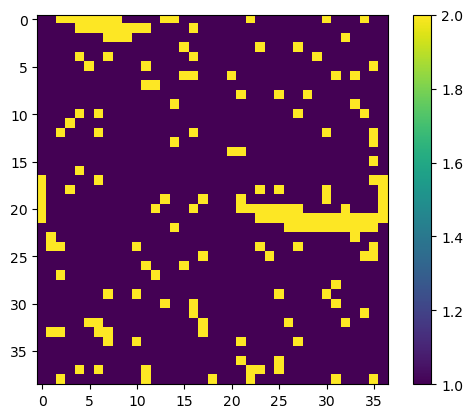

(39, 37)


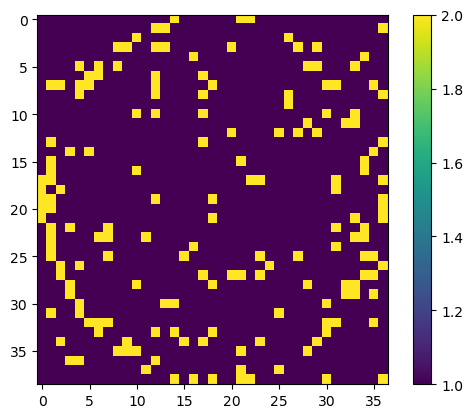

(51, 30)


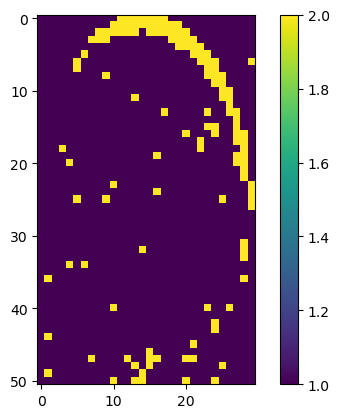

(41, 42)


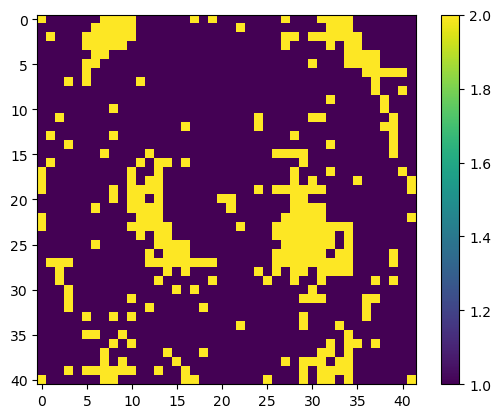

(38, 38)


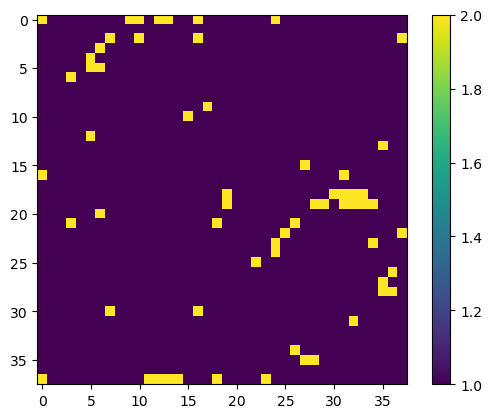

(30, 34)


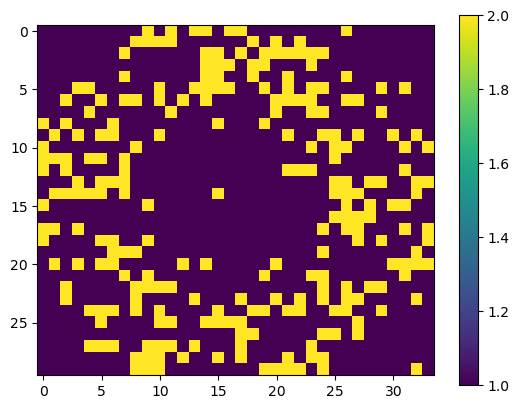

(26, 26)


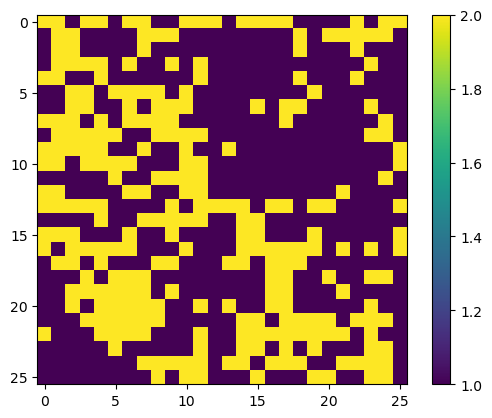

(34, 34)


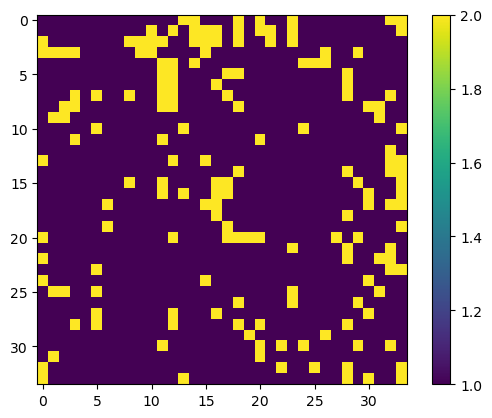

(41, 33)


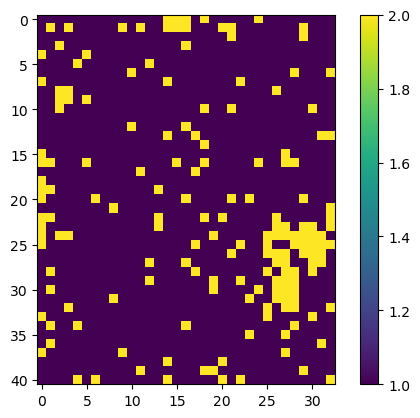

(26, 30)


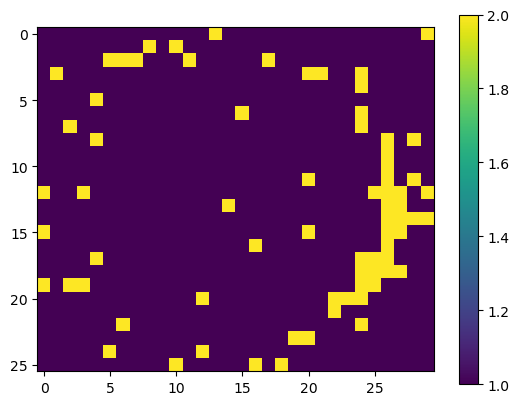

(41, 42)


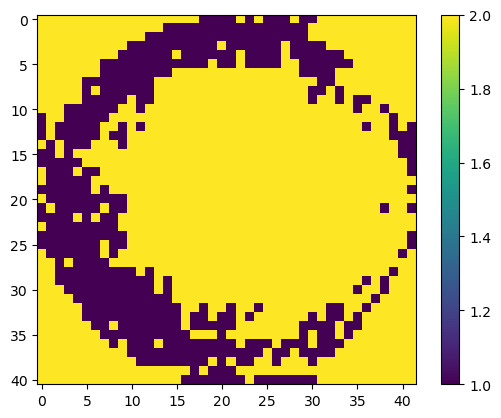

(30, 34)


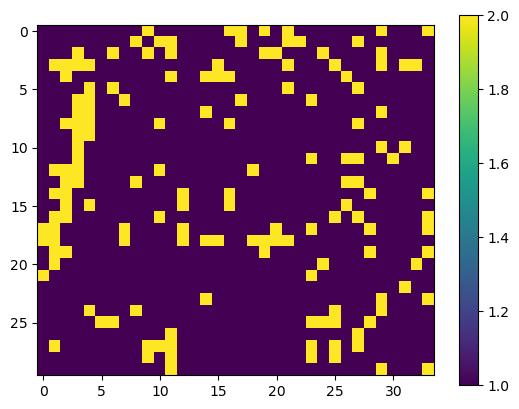

(50, 43)


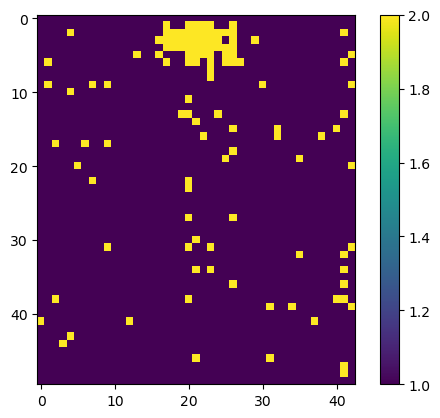

(39, 37)


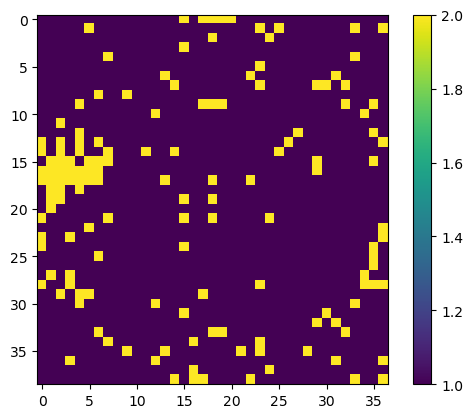

(33, 29)


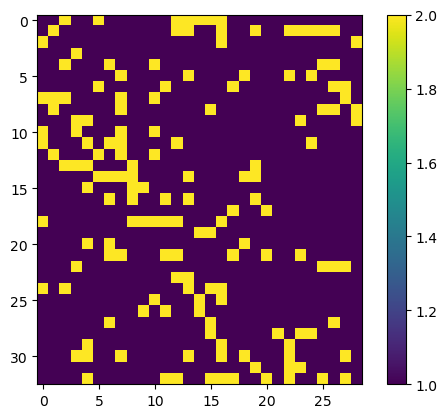

(34, 34)


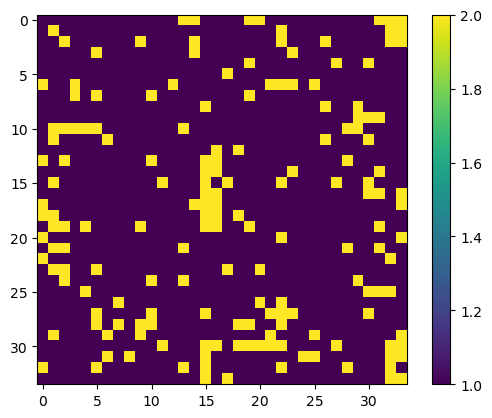

(25, 26)


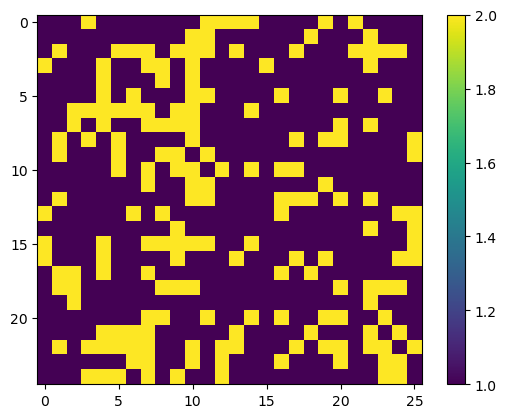

(44, 41)


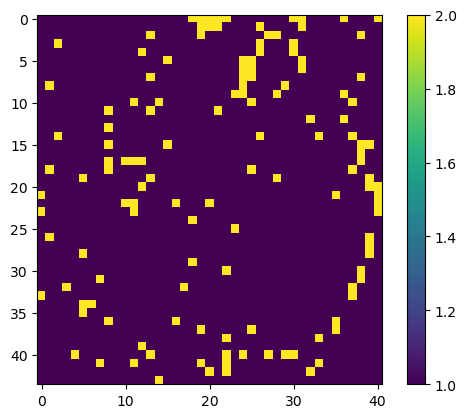

(51, 30)


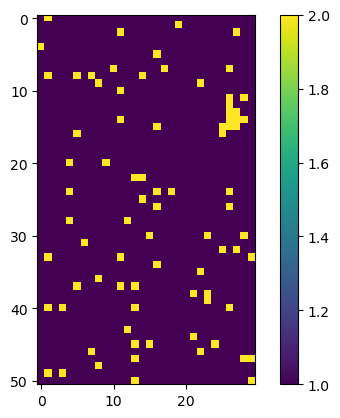

(39, 37)


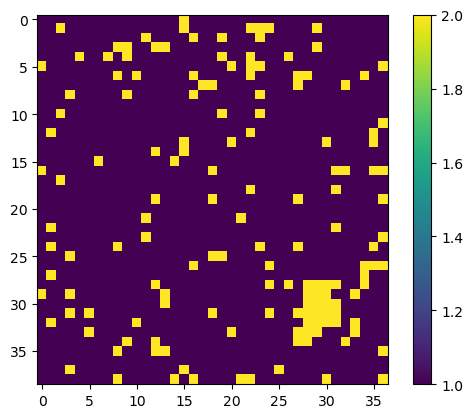

(63, 160)


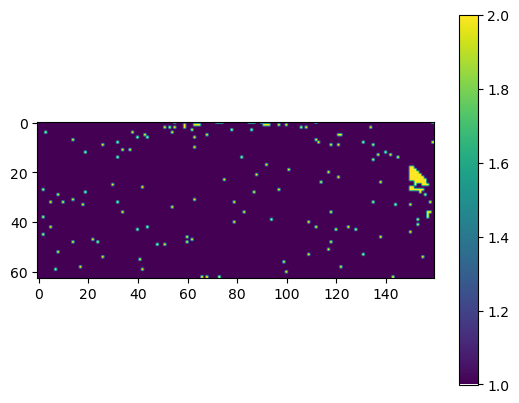

(41, 42)


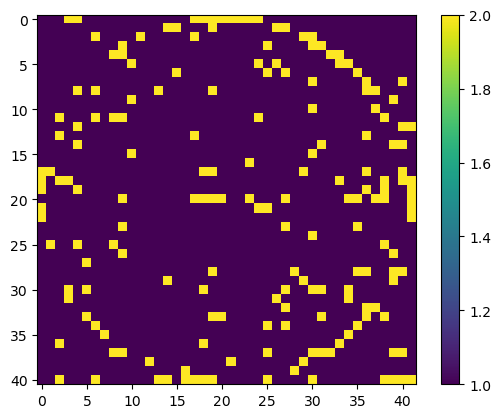

(38, 40)


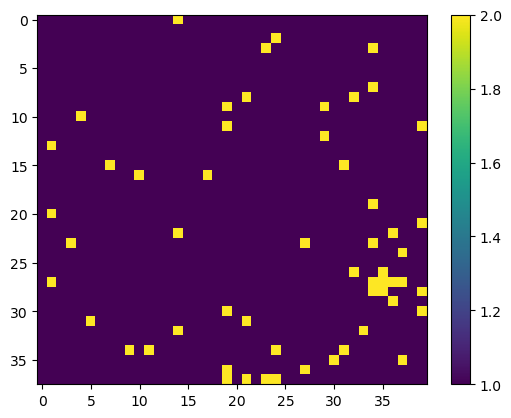

(26, 30)


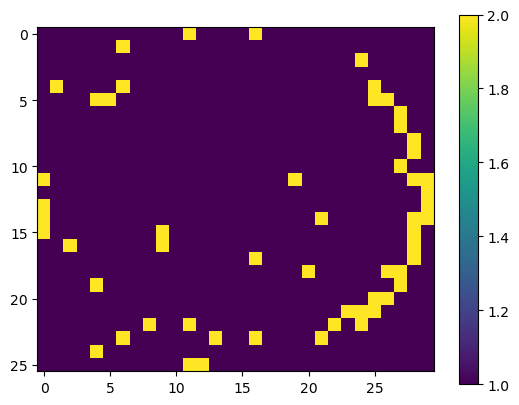

(41, 40)


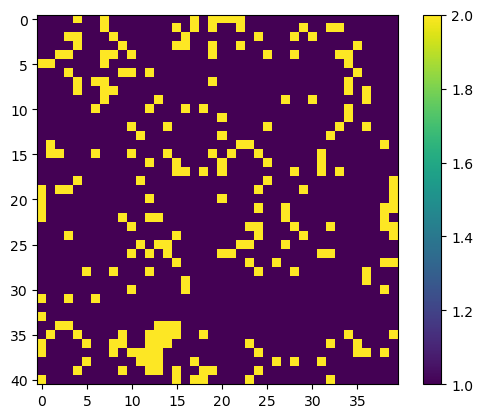

(26, 30)


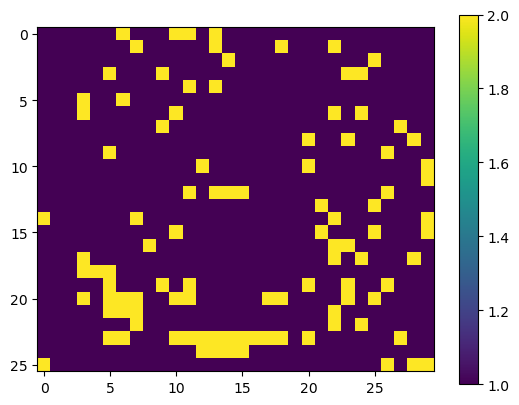

(38, 40)


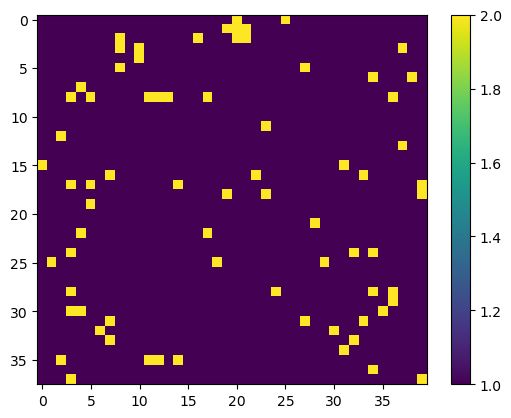

(38, 40)


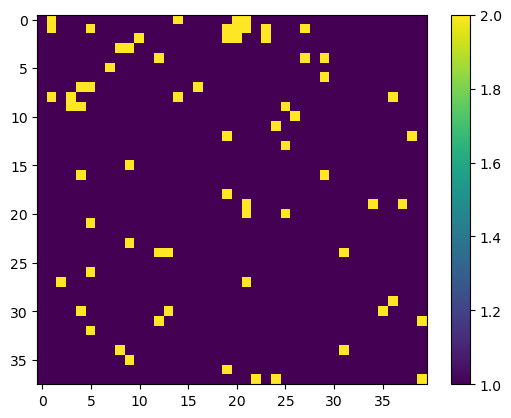

(41, 40)


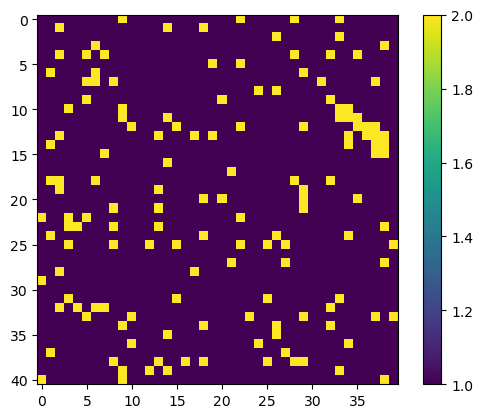

(26, 26)


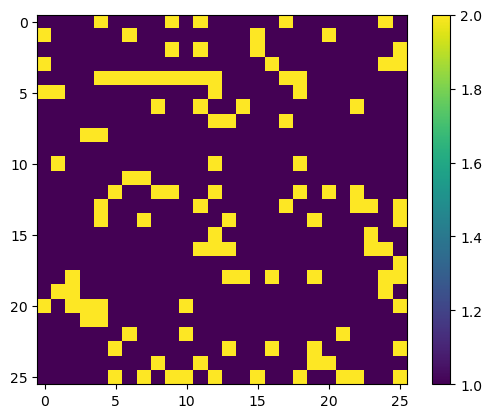

(34, 34)


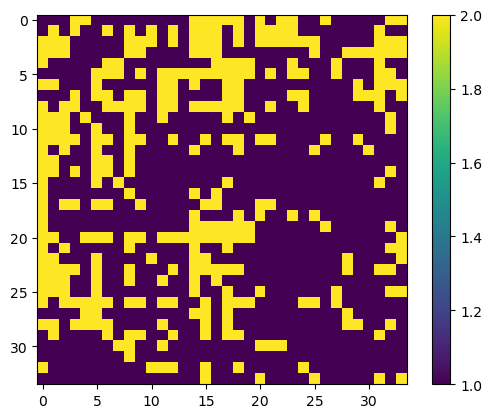

(30, 34)


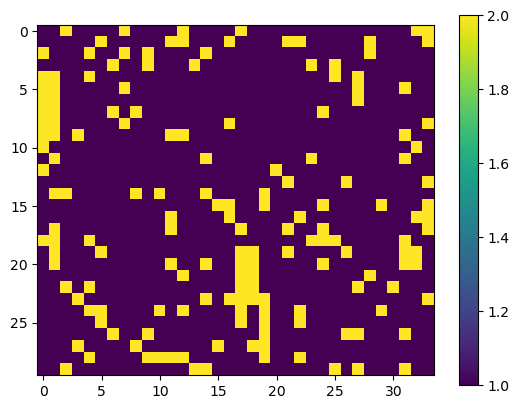

11min 27s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [5]:
%%timeit -r 1 -n 1

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)

print(f"平均精度：{average_accuracy*100:.2f}%")

# Confusion Matrixを計算
cm = confusion_matrix(y_test_df, user_result_df, labels=df['failureType'].unique())

# Confusion Matrixを可視化
ConfusionMatrixDisplay.from_predictions(y_test_df, user_result_df, xticks_rotation="vertical")
plt.show()

# 誤分類されたデータの抽出
misclassified_indices = y_test_df.index[y_test_df['failureType'] != user_result_df['failureType']]
misclassified_data = test_df.loc[misclassified_indices]

# 誤分類されたデータを表示
print("誤分類されたデータ:")
print(misclassified_data)
for map in misclassified_data['waferMap']:
    print(map.shape)
    show_img(map)

